# Spotify AI DJ - Sentiment Analysis

**Business Goal:** Understand public reception of Spotify's AI DJ feature through Twitter sentiment analysis.

**Key Questions:**

- How do users feel about the AI DJ overall?
- How has sentiment evolved since launch?
- What type of feedback gets the most engagement?
- How do emotional reactions differ from detailed feedback?


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For word cloud analysis
from wordcloud import WordCloud
import re
from collections import Counter

# Set style for clean, professional plots
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

## Step 1: Overall Sentiment Distribution

**Business Question:** What's the overall mood about AI DJ?


In [25]:
df = pd.read_csv("data/processed/tweets_with_sentiment.csv")

In [26]:
df.head()

,id,text,author_id,created_at,likes,retweets,replies,text_clean,text_length,sentiment,confidence
0,1961358481375518801,"@Spotify, can your AI DJ please stop sucking u...",1310212024253775872,2025-08-29 09:21:16+00:00,1,0,1,@user can your AI DJ please stop sucking up to...,142,negative,0.906410
1,1961360088419205571,@realfancy225 @Spotify @JonahKagen @ThisIsRobT...,1720665183188922368,2025-08-29 09:27:40+00:00,0,0,0,@user @user @user @user Totally agree—Spotify'...,262,positive,0.923209
2,1961387792279429319,@jaidenodavis @snseics1999 weird it’s exactly ...,1433597023576420365,2025-08-29 11:17:45+00:00,6,0,0,@user @user weird it’s exactly the “look” that...,305,negative,0.827388
3,1961390483772514589,🎧🤖 Meet your new AI DJ on Spotify — spinning t...,1936411644998893568,2025-08-29 11:28:26+00:00,0,0,0,🎧🤖 Meet your new AI DJ on Spotify — spinning t...,220,positive,0.862370
4,1961449992477970463,having the Spotify Ai DJ say my name to feel s...,747967587888271360,2025-08-29 15:24:54+00:00,1,0,1,having the Spotify Ai DJ say my name to feel s...,54,neutral,0.794417


In [27]:
df.shape

(144, 11)

In [31]:
# Calculate sentiment distribution
sentiment_counts = df["sentiment"].value_counts()
sentiment_pct = df["sentiment"].value_counts(normalize=True) * 100

print("Sentiment Distribution:")
for sentiment in sentiment_counts.index:
    count = sentiment_counts[sentiment]
    pct = sentiment_pct[sentiment]
    print(f"{sentiment.title()}: {count} tweets ({pct:.1f}%)")


Sentiment Distribution:
Neutral: 59 tweets (41.0%)
Positive: 54 tweets (37.5%)
Negative: 31 tweets (21.5%)


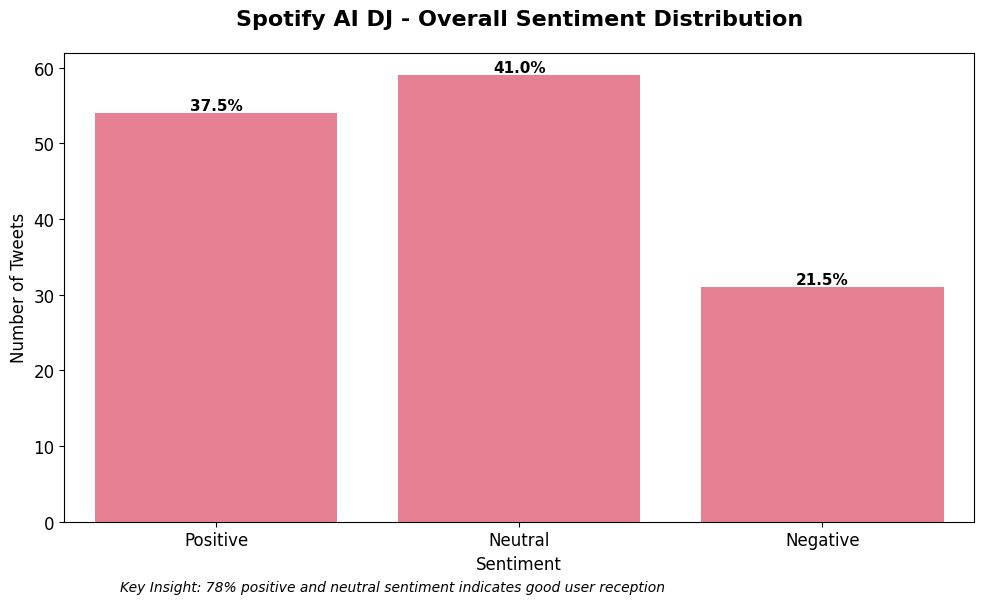

In [44]:
# Create clean bar chart
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="sentiment", order=["positive", "neutral", "negative"])

# Add percentage labels on bars
total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.title(
    "Spotify AI DJ - Overall Sentiment Distribution",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks([0, 1, 2], ["Positive", "Neutral", "Negative"])

# Add business insight as subtitle
positive_pct = sentiment_pct["positive"]
positive_and_neutral_pct = positive_pct + sentiment_pct["neutral"]
plt.figtext(
    0.4,
    0.00001,
    f"Key Insight: {positive_and_neutral_pct:.0f}% positive and neutral sentiment indicates good user reception",
    ha="center",
    fontsize=10,
    style="italic",
)

plt.tight_layout()
plt.show()


## Step 2: Sentiment Trend Over Time

**Business Question:** How has user sentiment evolved since AI DJ launch?


In [ ]:
# Filter data to include only tweets from after October 1st
df["created_at"] = pd.to_datetime(df["created_at"])
df_filtered = df[df["created_at"] >= "2025-10-01"]


print(f"Original dataset: {len(df)} tweets")
print(f"Filtered dataset (after Oct 1st): {len(df_filtered)} tweets")
print(
    f"Date range of filtered data: {df_filtered['created_at'].min()} to {df_filtered['created_at'].max()}"
)

# Show sentiment distribution for filtered data
if len(df_filtered) > 0:
    filtered_sentiment_counts = df_filtered["sentiment"].value_counts()
    print("\nSentiment distribution for tweets after Oct 1st:")
    for sentiment in filtered_sentiment_counts.index:
        count = filtered_sentiment_counts[sentiment]
        pct = (count / len(df_filtered)) * 100
        print(f"{sentiment.title()}: {count} tweets ({pct:.1f}%)")
else:
    print("No tweets found after October 1st, 2025")


Original dataset: 144 tweets
Filtered dataset (after Oct 1st): 97 tweets
Date range of filtered data: 2025-10-13 13:44:28+00:00 to 2025-10-18 17:58:45+00:00

Sentiment distribution for tweets after Oct 1st:
Neutral: 46 tweets (47.4%)
Positive: 36 tweets (37.1%)
Negative: 15 tweets (15.5%)


In [ ]:
# Prepare data for time series analysis
# First ensure created_at is datetime
# df["created_at"] = pd.to_datetime(df["created_at"])
df_time = df_filtered.set_index("created_at")

# Resample by day and calculate sentiment proportions
# For DatetimeIndex, use .date directly (no .dt accessor needed)
daily_sentiment = (
    df_time.groupby([df_time.index.date, "sentiment"]).size().unstack(fill_value=0)
)
daily_sentiment_pct = daily_sentiment.div(daily_sentiment.sum(axis=1), axis=0) * 100

print(f"Time range: {len(daily_sentiment)} days of data")
daily_sentiment_pct.head()


Time range: 6 days of data


sentiment,negative,neutral,positive
2025-10-13,20.000000,60.000000,20.000000
2025-10-14,11.111111,33.333333,55.555556
2025-10-15,10.256410,56.410256,33.333333
2025-10-16,18.518519,40.740741,40.740741
2025-10-17,25.000000,50.000000,25.000000


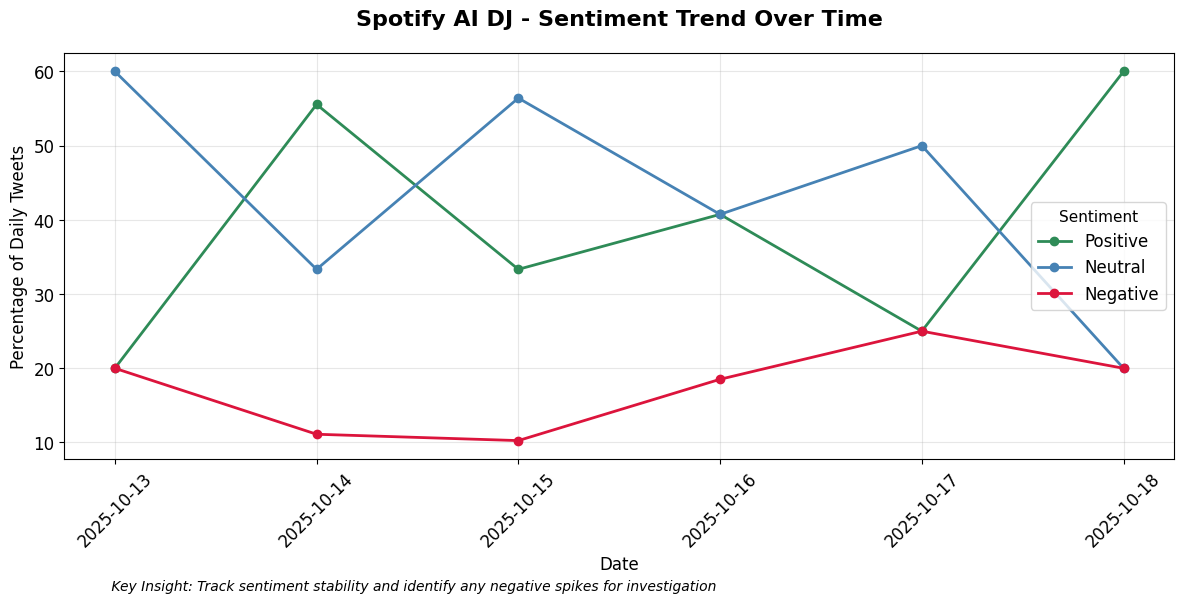

In [ ]:
# Create time series plot
plt.figure(figsize=(12, 6))

# Plot each sentiment as a line
colors = {"positive": "#2E8B57", "neutral": "#4682B4", "negative": "#DC143C"}
for sentiment in ["positive", "neutral", "negative"]:
    if sentiment in daily_sentiment_pct.columns:
        plt.plot(
            daily_sentiment_pct.index,
            daily_sentiment_pct[sentiment],
            marker="o",
            linewidth=2,
            label=sentiment.title(),
            color=colors[sentiment],
        )

plt.title(
    "Spotify AI DJ - Sentiment Trend Over Time", fontsize=16, fontweight="bold", pad=20
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage of Daily Tweets", fontsize=12)
plt.legend(title="Sentiment", title_fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


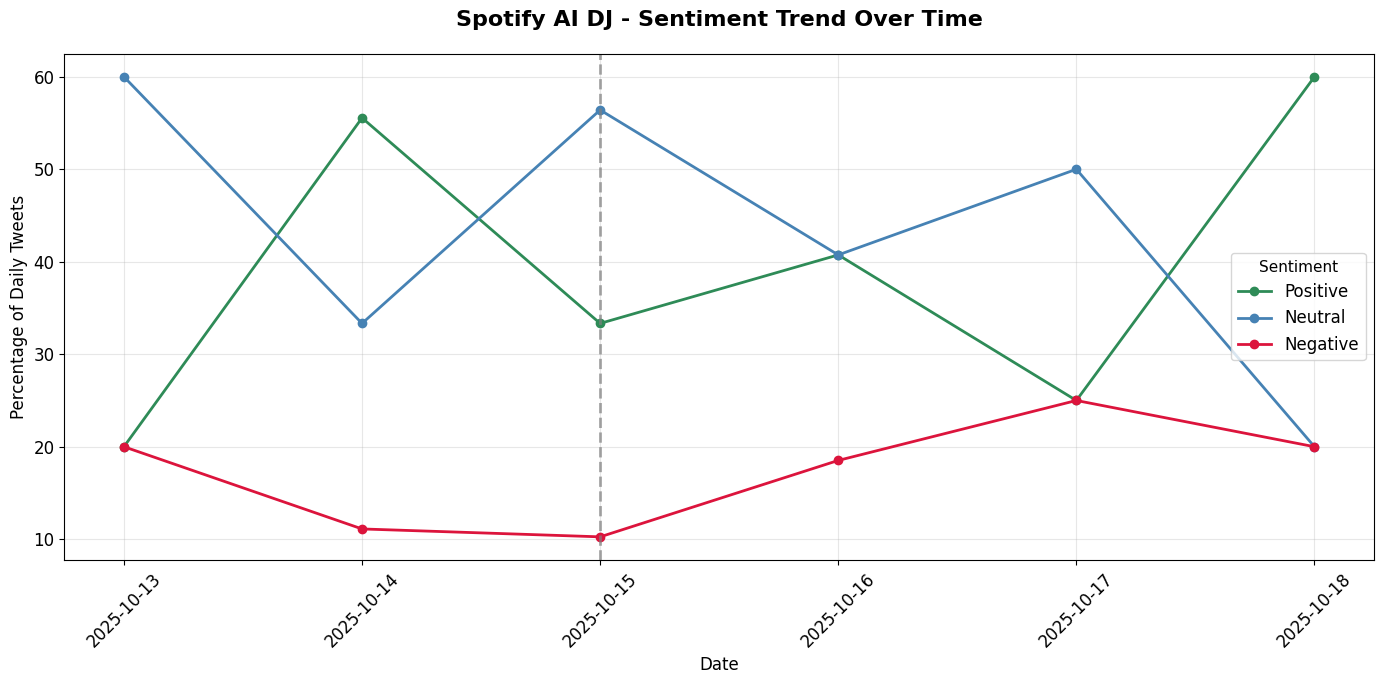

In [69]:
plt.figure(figsize=(14, 7))

# Plot each sentiment as a line
colors = {"positive": "#2E8B57", "neutral": "#4682B4", "negative": "#DC143C"}
for sentiment in ["positive", "neutral", "negative"]:
    if sentiment in daily_sentiment_pct.columns:
        plt.plot(
            daily_sentiment_pct.index,
            daily_sentiment_pct[sentiment],
            marker="o",
            linewidth=2,
            label=sentiment.title(),
            color=colors[sentiment],
        )

plt.title(
    "Spotify AI DJ - Sentiment Trend Over Time", fontsize=16, fontweight="bold", pad=20
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Percentage of Daily Tweets", fontsize=12)
plt.legend(title="Sentiment", title_fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add vertical line at October 15th and include it in the legend
release_date = pd.Timestamp("2025-10-15")
plt.axvline(
    x=release_date,
    color="grey",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Dj Levels Up!",
)

# Add legend or update it to include the vertical line's label
# plt.legend(title="Sentiment & Events", title_fontsize=11)


plt.tight_layout()
plt.show()


to modify


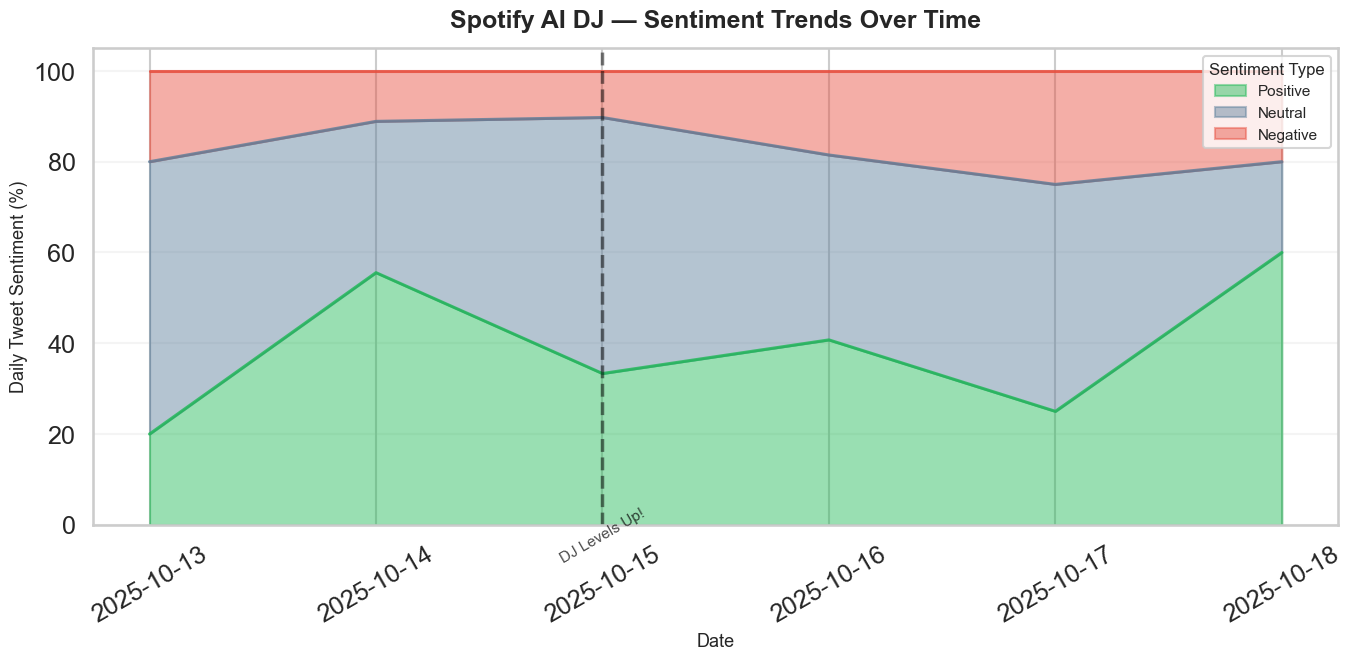

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Seaborn style
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.1)

# Define consistent color palette (Spotify-inspired but muted)
colors = {
    "positive": "#1DB954",  # Spotify green
    "neutral": "#5A7D9A",  # calm blue-gray
    "negative": "#E74C3C",  # soft red
}

# Extract series
x = daily_sentiment_reset[date_col]
y1 = daily_sentiment_reset.get("positive", 0)
y2 = daily_sentiment_reset.get("neutral", 0)
y3 = daily_sentiment_reset.get("negative", 0)

# Create figure
plt.figure(figsize=(14, 7))

# Stack areas with softer transparency and smoother edges
plt.fill_between(x, 0, y1, color=colors["positive"], alpha=0.45, label="Positive")
plt.fill_between(x, y1, y1 + y2, color=colors["neutral"], alpha=0.45, label="Neutral")
plt.fill_between(
    x, y1 + y2, y1 + y2 + y3, color=colors["negative"], alpha=0.45, label="Negative"
)

# Add outline lines for better contrast
plt.plot(x, y1, color=colors["positive"], linewidth=2.2, alpha=0.8)
plt.plot(x, y1 + y2, color=colors["neutral"], linewidth=2.2, alpha=0.8)
plt.plot(x, y1 + y2 + y3, color=colors["negative"], linewidth=2.2, alpha=0.8)

# Add event marker
release_date = pd.Timestamp("2025-10-15")
plt.axvline(x=release_date, color="black", linestyle="--", linewidth=2.5, alpha=0.5)
plt.text(
    release_date,
    -9,
    "DJ Levels Up!",
    rotation=30,
    va="bottom",
    ha="center",
    fontsize=11,
    color="black",
    alpha=0.7,
)

# Titles and labels
plt.title(
    "Spotify AI DJ — Sentiment Trends Over Time", fontsize=18, weight="bold", pad=15
)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Daily Tweet Sentiment (%)", fontsize=13)

# Grid and legend
plt.grid(axis="y", alpha=0.2)
plt.legend(
    title="Sentiment Type",
    title_fontsize=12,
    fontsize=11,
    loc="upper right",
    # frameon=False,
)

# Ticks and layout
plt.xticks(rotation=30)
plt.ylim(0, 105)
plt.tight_layout()
plt.show()


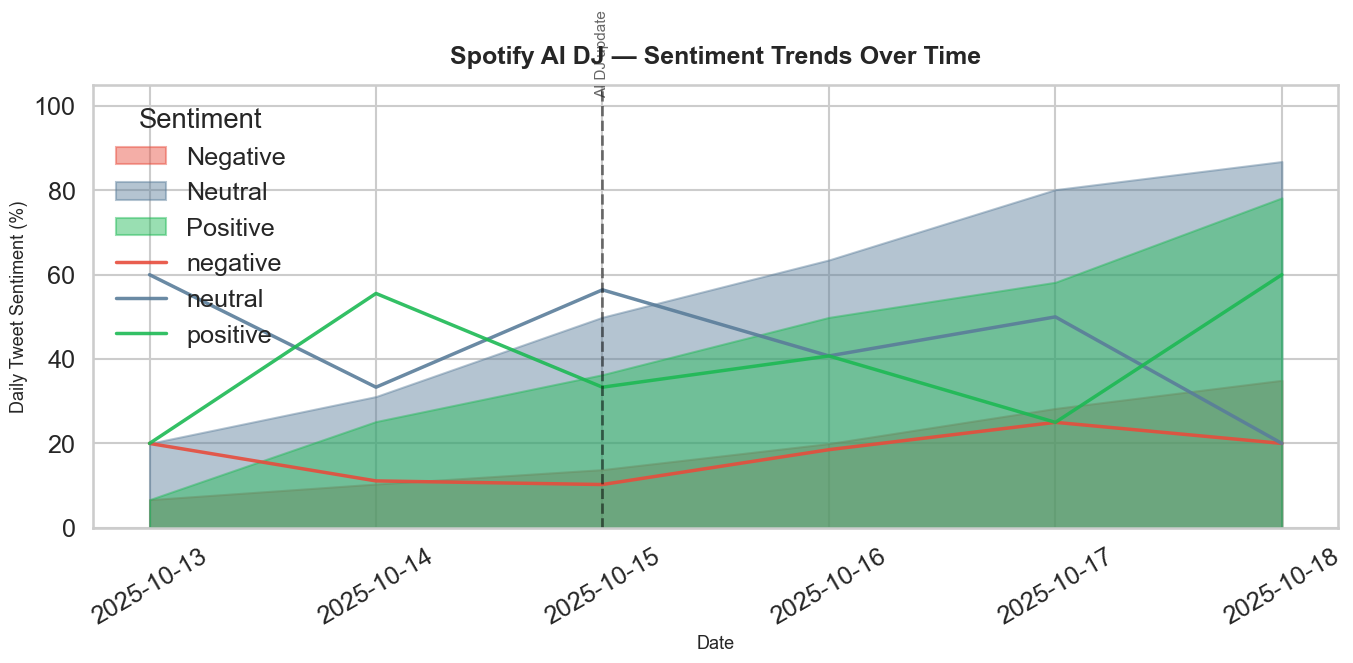

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.1)

# Spotify-inspired palette
palette = {
    "positive": "#1DB954",  # green
    "neutral": "#5A7D9A",  # blue-gray
    "negative": "#E74C3C",  # red
}

# Melt your wide table to long form for seaborn
df_long = daily_sentiment_reset.melt(
    id_vars=date_col,
    value_vars=["positive", "neutral", "negative"],
    var_name="sentiment",
    value_name="percentage",
)

# Sort for nice stacking order
order = ["negative", "neutral", "positive"]
df_long["sentiment"] = pd.Categorical(
    df_long["sentiment"], categories=order, ordered=True
)

plt.figure(figsize=(14, 7))

# Plot one area per sentiment (using alpha for transparency)
for sentiment in order:
    subset = df_long[df_long["sentiment"] == sentiment]
    plt.fill_between(
        subset[date_col],
        subset["percentage"].cumsum() / len(order),  # slight stacking illusion
        color=palette[sentiment],
        alpha=0.45,
        label=sentiment.capitalize(),
    )

# Draw smoothed sentiment lines
sns.lineplot(
    data=df_long,
    x=date_col,
    y="percentage",
    hue="sentiment",
    hue_order=order,
    palette=palette,
    linewidth=2.5,
    alpha=0.9,
)

# Event marker
release_date = pd.Timestamp("2025-10-15")
plt.axvline(x=release_date, color="black", linestyle="--", linewidth=2, alpha=0.5)
plt.text(
    release_date,
    102,
    "AI DJ update",
    rotation=90,
    va="bottom",
    ha="center",
    fontsize=11,
    alpha=0.7,
)

# Labels and legend
plt.title(
    "Spotify AI DJ — Sentiment Trends Over Time", fontsize=18, weight="bold", pad=15
)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Daily Tweet Sentiment (%)", fontsize=13)
plt.legend(title="Sentiment", loc="upper left", frameon=False)
plt.ylim(0, 105)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


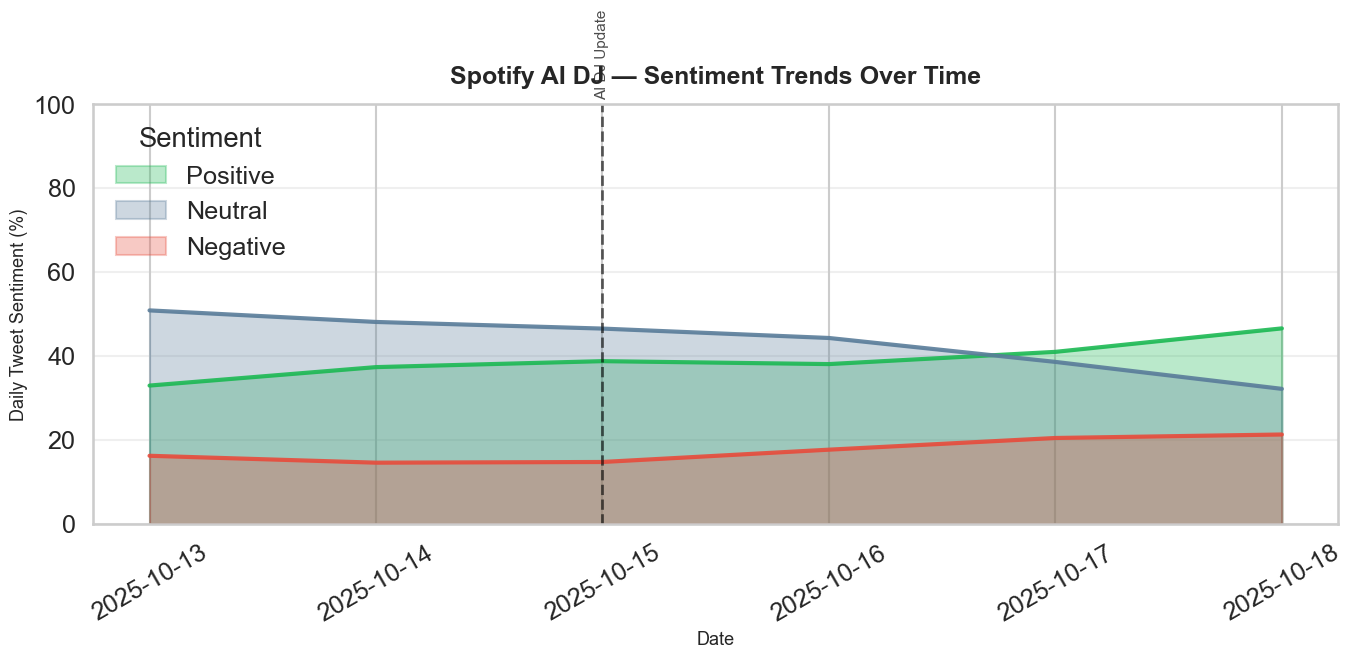

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Set style and context
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.1)

# Spotify-inspired palette
palette = {
    "positive": "#1DB954",  # Spotify green
    "neutral": "#5A7D9A",  # blue-gray
    "negative": "#E74C3C",  # coral red
}

# Smooth curves slightly
df_smooth = daily_sentiment_reset.copy()
for col in ["positive", "neutral", "negative"]:
    if col in df_smooth:
        df_smooth[col] = gaussian_filter1d(df_smooth[col], sigma=1.2)

# Create figure
plt.figure(figsize=(14, 7))

# Plot filled areas (no stacking)
for sentiment in ["positive", "neutral", "negative"]:
    if sentiment in df_smooth:
        plt.fill_between(
            df_smooth[date_col],
            df_smooth[sentiment],
            color=palette[sentiment],
            alpha=0.3,
            label=sentiment.capitalize(),
        )
        plt.plot(
            df_smooth[date_col],
            df_smooth[sentiment],
            color=palette[sentiment],
            linewidth=3,
            alpha=0.9,
        )

# Add vertical event line
release_date = pd.Timestamp("2025-10-15")
plt.axvline(x=release_date, color="black", linestyle="--", linewidth=2, alpha=0.6)
plt.text(
    release_date,
    101,
    "AI DJ Update",
    rotation=90,
    va="bottom",
    ha="center",
    fontsize=11,
    color="black",
    alpha=0.7,
)

# Labels & titles
plt.title(
    "Spotify AI DJ — Sentiment Trends Over Time", fontsize=18, weight="bold", pad=15
)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Daily Tweet Sentiment (%)", fontsize=13)
plt.legend(title="Sentiment", loc="upper left", frameon=False)
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Step 3: Engagement vs Sentiment

**Business Question:** Which sentiment drives the most social engagement?


In [70]:
# Calculate average engagement metrics by sentiment
engagement_by_sentiment = (
    df.groupby("sentiment")[["likes", "retweets", "replies"]].mean().round(2)
)

print("Average Engagement by Sentiment:")
print(engagement_by_sentiment)


Average Engagement by Sentiment:
           likes  retweets  replies
sentiment                          
negative    3.55      0.10     0.74
neutral     1.98      0.29     0.34
positive    2.44      0.43     0.69


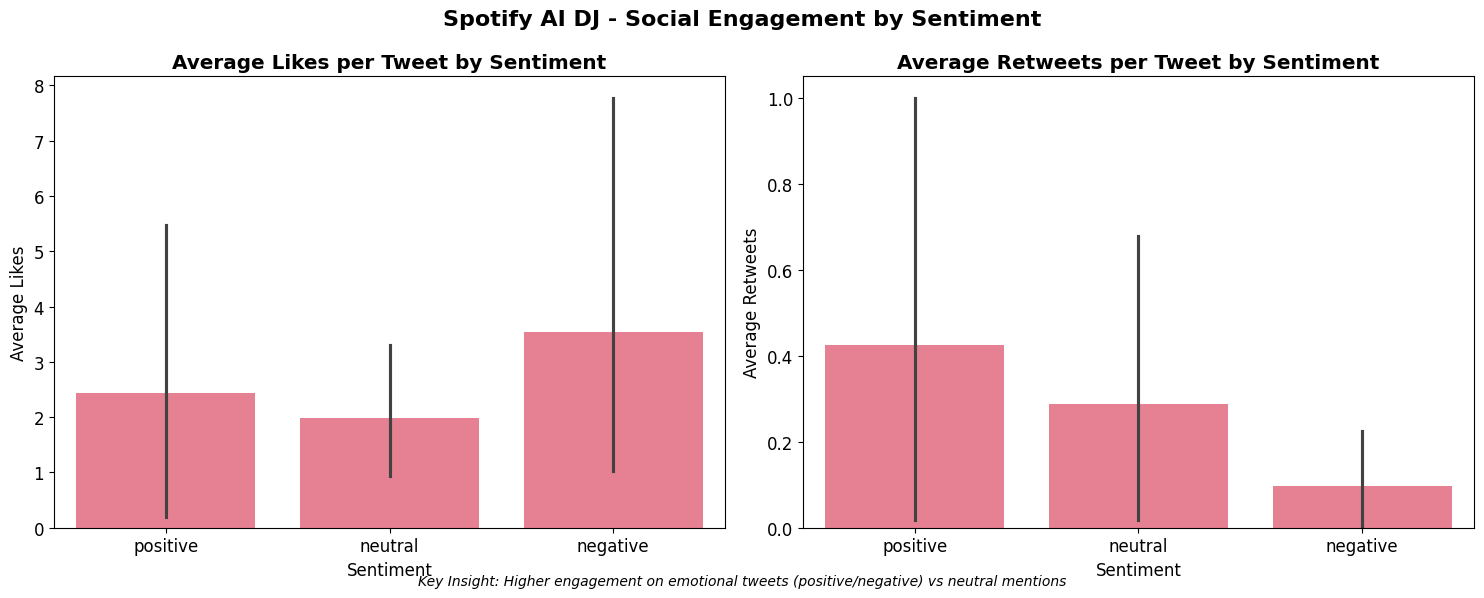

In [71]:
# Create engagement comparison plot using seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Average likes per sentiment
sns.barplot(
    data=df, x="sentiment", y="likes", ax=ax1, order=["positive", "neutral", "negative"]
)
ax1.set_title("Average Likes per Tweet by Sentiment", fontweight="bold")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Average Likes")

# Average retweets per sentiment
sns.barplot(
    data=df,
    x="sentiment",
    y="retweets",
    ax=ax2,
    order=["positive", "neutral", "negative"],
)
ax2.set_title("Average Retweets per Tweet by Sentiment", fontweight="bold")
ax2.set_xlabel("Sentiment")
ax2.set_ylabel("Average Retweets")

plt.suptitle(
    "Spotify AI DJ - Social Engagement by Sentiment", fontsize=16, fontweight="bold"
)
plt.figtext(
    0.5,
    0.02,
    "Key Insight: Higher engagement on emotional tweets (positive/negative) vs neutral mentions",
    ha="center",
    fontsize=10,
    style="italic",
)

plt.tight_layout()
plt.show()


## Step 4: Text Length vs Sentiment

**Business Question:** Do emotional reactions differ from detailed feedback?


In [72]:
# Calculate average text length by sentiment
length_by_sentiment = (
    df.groupby("sentiment")["text_length"].agg(["mean", "median"]).round(1)
)

print("Text Length Statistics by Sentiment:")
print(length_by_sentiment)


Text Length Statistics by Sentiment:
            mean  median
sentiment               
negative   157.6   149.0
neutral    103.1    92.0
positive   174.8   165.5


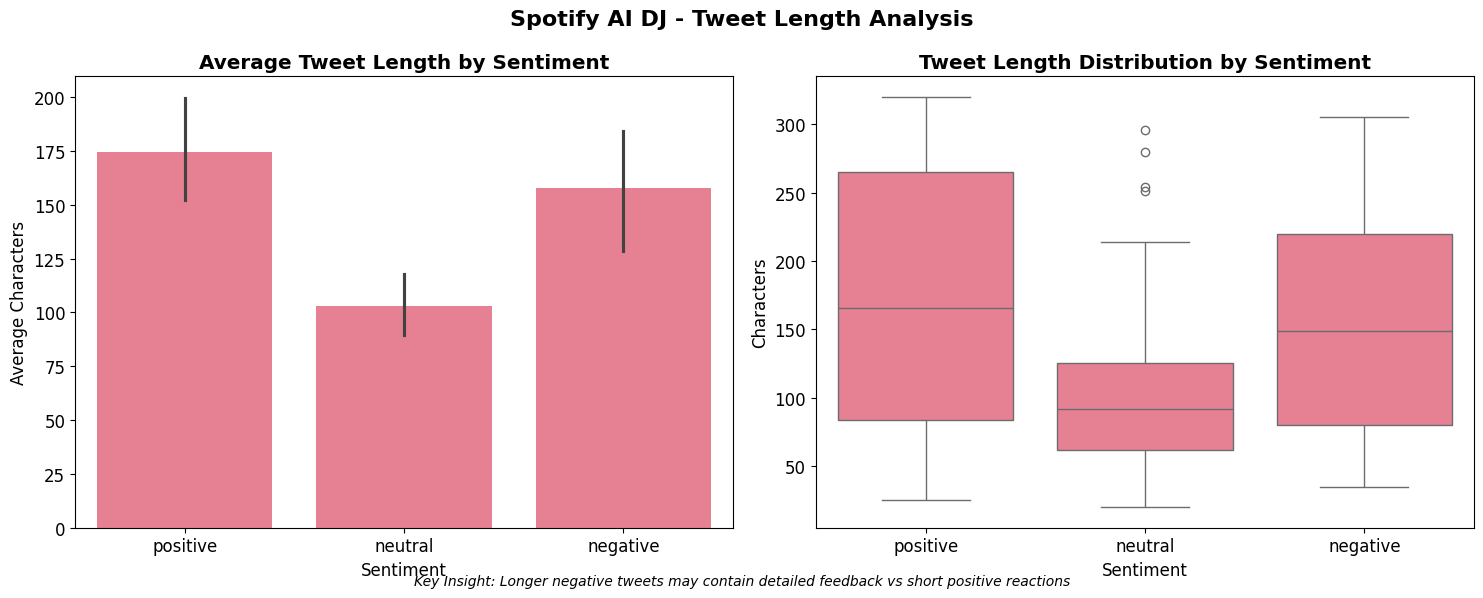

In [73]:
# Create text length comparison plots using seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of average length
sns.barplot(
    data=df,
    x="sentiment",
    y="text_length",
    ax=ax1,
    order=["positive", "neutral", "negative"],
)
ax1.set_title("Average Tweet Length by Sentiment", fontweight="bold")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Average Characters")

# Box plot for distribution
sns.boxplot(
    data=df,
    x="sentiment",
    y="text_length",
    ax=ax2,
    order=["positive", "neutral", "negative"],
)
ax2.set_title("Tweet Length Distribution by Sentiment", fontweight="bold")
ax2.set_xlabel("Sentiment")
ax2.set_ylabel("Characters")

plt.suptitle("Spotify AI DJ - Tweet Length Analysis", fontsize=16, fontweight="bold")
plt.figtext(
    0.5,
    0.02,
    "Key Insight: Longer negative tweets may contain detailed feedback vs short positive reactions",
    ha="center",
    fontsize=10,
    style="italic",
)

plt.tight_layout()
plt.show()


## Summary & Business Insights

**Key findings for Spotify AI DJ product team:**


In [ ]:
# Generate automated insights
total_tweets = len(df)
pos_pct = (df["sentiment"] == "positive").mean() * 100
neg_pct = (df["sentiment"] == "negative").mean() * 100
neu_pct = (df["sentiment"] == "neutral").mean() * 100

print("🎯 SPOTIFY AI DJ - SENTIMENT ANALYSIS SUMMARY")
print("=" * 50)
print(f"📊 Dataset: {total_tweets} tweets analyzed")
print(f"📅 Time period: {df['created_at'].min()} to {df['created_at'].max()}")
print()
print("🎭 SENTIMENT BREAKDOWN:")
print(
    f"   ✅ Positive: {pos_pct:.1f}% ({(df['sentiment'] == 'positive').sum()} tweets)"
)
print(f"   ⚪ Neutral:  {neu_pct:.1f}% ({(df['sentiment'] == 'neutral').sum()} tweets)")
print(
    f"   ❌ Negative: {neg_pct:.1f}% ({(df['sentiment'] == 'negative').sum()} tweets)"
)
print()
print("💡 BUSINESS RECOMMENDATIONS:")
if pos_pct > 50:
    print("   ✅ Strong positive reception - consider amplifying success stories")
if neg_pct > 20:
    print("   ⚠️  Significant negative feedback - analyze for product improvements")
print("   🎯 Monitor sentiment trends for feature release impact")


🎯 SPOTIFY AI DJ - SENTIMENT ANALYSIS SUMMARY
📊 Dataset: 144 tweets analyzed
📅 Time period: 2025-08-29 09:21:16+00:00 to 2025-10-18 17:58:45+00:00

🎭 SENTIMENT BREAKDOWN:
   ✅ Positive: 37.5% (54 tweets)
   ⚪ Neutral:  41.0% (59 tweets)
   ❌ Negative: 21.5% (31 tweets)

💡 BUSINESS RECOMMENDATIONS:
   ⚠️  Significant negative feedback - analyze for product improvements
   🎯 Monitor sentiment trends for feature release impact


## Word Cloud Analysis

**Exploratory Analysis:** What words characterize each sentiment?


In [ ]:
# Text preprocessing for word clouds
def clean_text_for_wordcloud(text):
    """Clean text by removing URLs, mentions, and common filler words"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions (@user), and special characters
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", " ", text)

    # Define common filler words to remove (including Spotify-specific terms we want to exclude)
    filler_words = {
        "the",
        "a",
        "an",
        "and",
        "or",
        "but",
        "in",
        "on",
        "at",
        "to",
        "for",
        "of",
        "with",
        "by",
        "is",
        "are",
        "was",
        "were",
        "be",
        "been",
        "being",
        "have",
        "has",
        "had",
        "do",
        "does",
        "did",
        "will",
        "would",
        "could",
        "should",
        "may",
        "might",
        "can",
        "must",
        "shall",
        "i",
        "you",
        "he",
        "she",
        "it",
        "we",
        "they",
        "me",
        "him",
        "her",
        "us",
        "them",
        "my",
        "your",
        "his",
        "her",
        "its",
        "our",
        "their",
        "this",
        "that",
        "these",
        "those",
        "spotify",
        "ai",
        "music",
        "new",
        "dj",
        "user",  # Remove these since they're in every tweet
    }

    # Split into words and filter
    words = text.split()
    filtered_words = [
        word for word in words if word not in filler_words and len(word) > 2
    ]

    return " ".join(filtered_words)


# Test the function
sample_text = "I love the Spotify AI DJ feature, it's amazing!"
print("Original:", sample_text)
print("Cleaned:", clean_text_for_wordcloud(sample_text))


Original: I love the Spotify AI DJ feature, it's amazing!
Cleaned: love feature amazing


In [84]:
# Create sentiment subsets for word cloud analysis
positive_tweets = df[df["sentiment"] == "positive"]
negative_tweets = df[df["sentiment"] == "negative"]
neutral_tweets = df[df["sentiment"] == "neutral"]

print(f"Positive tweets: {len(positive_tweets)}")
print(f"Negative tweets: {len(negative_tweets)}")
print(f"Neutral tweets: {len(neutral_tweets)}")


Positive tweets: 54
Negative tweets: 31
Neutral tweets: 59


Creating word cloud for 54 positive tweets...


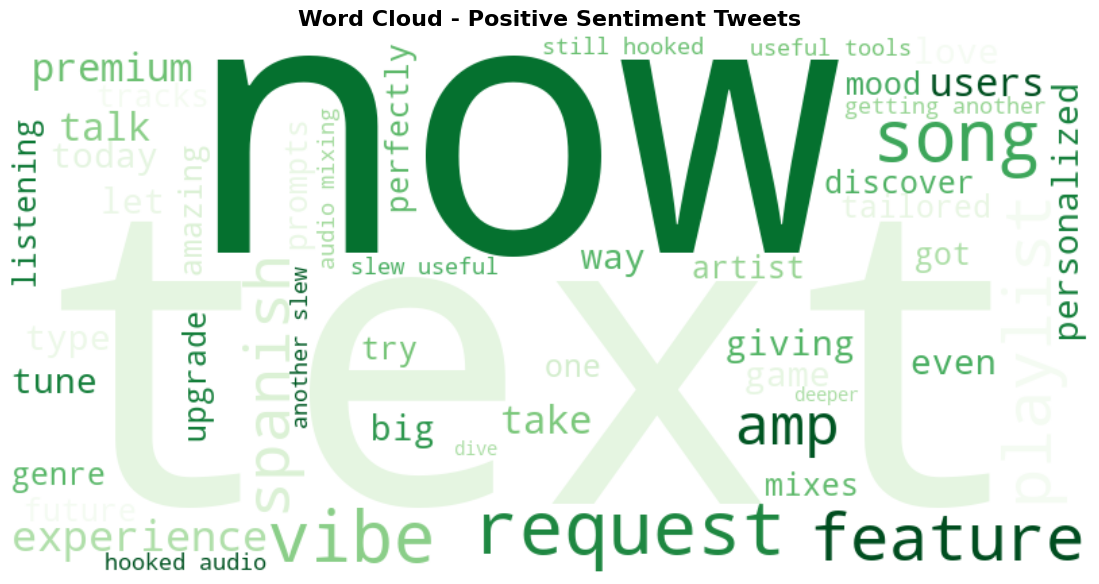


Top 10 words in positive tweets:
http: 33
just: 14
text: 14
now: 11
requests: 9
spanish: 8
like: 7
more: 7
songs: 7
vibe: 7


In [86]:
# Create word cloud for POSITIVE sentiment tweets
print(f"Creating word cloud for {len(positive_tweets)} positive tweets...")

# Combine all positive tweet texts
positive_text = " ".join(positive_tweets["text_clean"].astype(str))
positive_cleaned = clean_text_for_wordcloud(positive_text)

# Create word cloud
plt.figure(figsize=(12, 6))
wordcloud_positive = WordCloud(
    width=800, height=400, background_color="white", colormap="Greens", max_words=50
).generate(positive_cleaned)

plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment Tweets", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Show most common words in positive tweets
positive_words = positive_cleaned.split()
positive_word_counts = Counter(positive_words)
print("\nTop 10 words in positive tweets:")
for word, count in positive_word_counts.most_common(10):
    print(f"{word}: {count}")


Creating word cloud for 31 negative tweets...


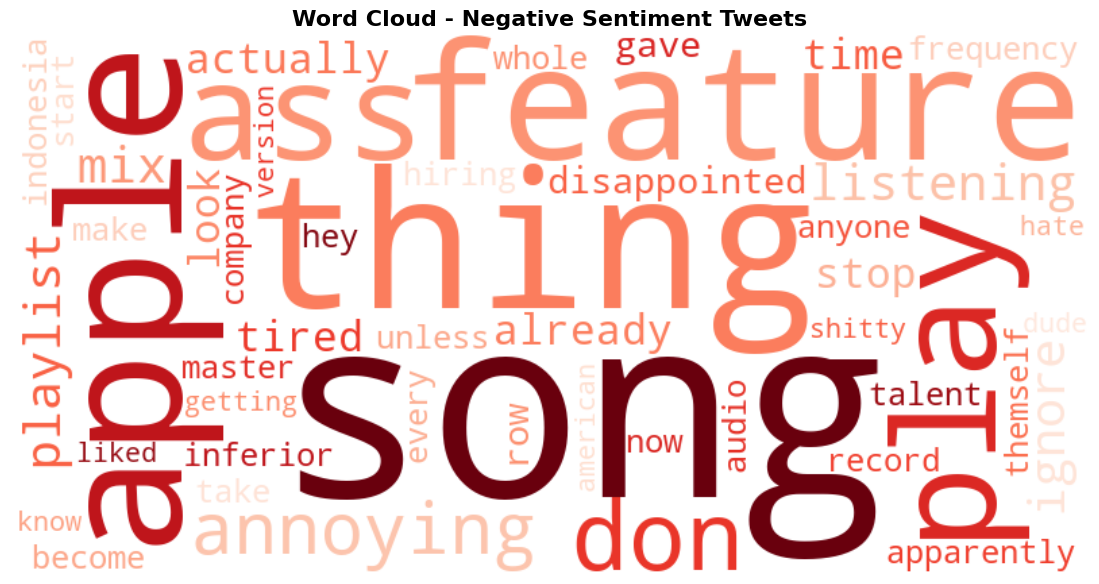


Top 10 words in negative tweets:
like: 9
songs: 7
some: 7
just: 6
thing: 5
http: 5
apple: 4
when: 3
why: 3
only: 3


In [87]:
# Create word cloud for NEGATIVE sentiment tweets
print(f"Creating word cloud for {len(negative_tweets)} negative tweets...")

# Combine all negative tweet texts
negative_text = " ".join(negative_tweets["text_clean"].astype(str))
negative_cleaned = clean_text_for_wordcloud(negative_text)

# Create word cloud
plt.figure(figsize=(12, 6))
wordcloud_negative = WordCloud(
    width=800, height=400, background_color="white", colormap="Reds", max_words=50
).generate(negative_cleaned)

plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment Tweets", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Show most common words in negative tweets
negative_words = negative_cleaned.split()
negative_word_counts = Counter(negative_words)
print("\nTop 10 words in negative tweets:")
for word, count in negative_word_counts.most_common(10):
    print(f"{word}: {count}")


Creating word cloud for 59 neutral tweets...


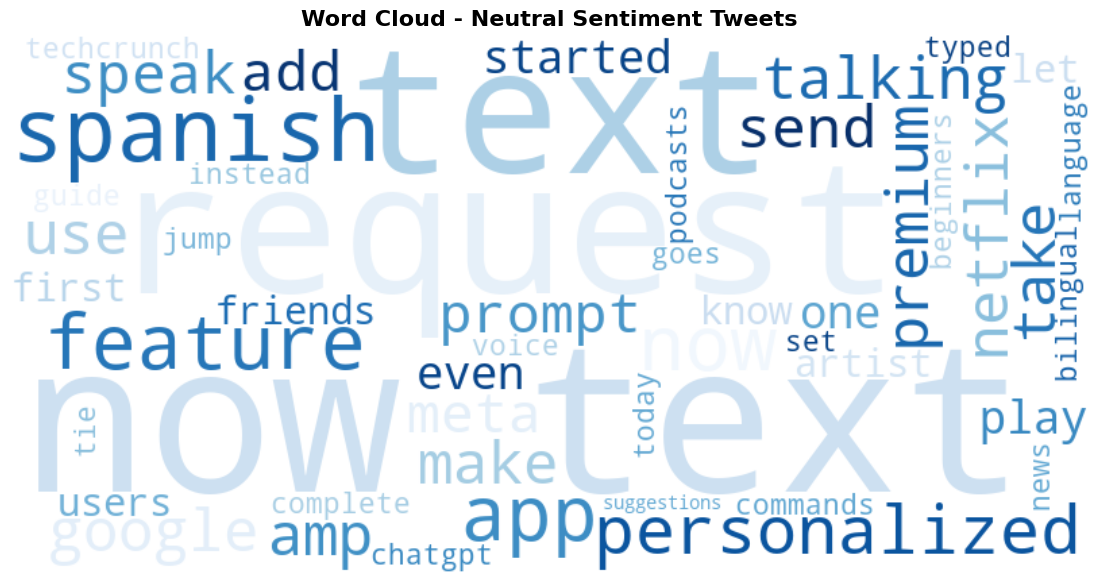


Top 10 words in neutral tweets:
http: 31
text: 24
now: 19
requests: 10
spanish: 7
just: 5
like: 4
how: 4
personalized: 4
feature: 3


In [88]:
# Create word cloud for NEUTRAL sentiment tweets
print(f"Creating word cloud for {len(neutral_tweets)} neutral tweets...")

# Combine all neutral tweet texts
neutral_text = " ".join(neutral_tweets["text_clean"].astype(str))
neutral_cleaned = clean_text_for_wordcloud(neutral_text)

# Create word cloud
plt.figure(figsize=(12, 6))
wordcloud_neutral = WordCloud(
    width=800, height=400, background_color="white", colormap="Blues", max_words=50
).generate(neutral_cleaned)

plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment Tweets", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Show most common words in neutral tweets
neutral_words = neutral_cleaned.split()
neutral_word_counts = Counter(neutral_words)
print("\nTop 10 words in neutral tweets:")
for word, count in neutral_word_counts.most_common(10):
    print(f"{word}: {count}")


In [81]:
# Compare top words across sentiments
print("=== WORD COMPARISON ACROSS SENTIMENTS ===\n")

# Get top 15 words for each sentiment
top_positive = dict(positive_word_counts.most_common(15))
top_negative = dict(negative_word_counts.most_common(15))
top_neutral = dict(neutral_word_counts.most_common(15))

print("Words unique to POSITIVE sentiment:")
positive_unique = (
    set(top_positive.keys()) - set(top_negative.keys()) - set(top_neutral.keys())
)
for word in list(positive_unique)[:10]:
    print(f"  {word}: {top_positive[word]}")

print("\nWords unique to NEGATIVE sentiment:")
negative_unique = (
    set(top_negative.keys()) - set(top_positive.keys()) - set(top_neutral.keys())
)
for word in list(negative_unique)[:10]:
    print(f"  {word}: {top_negative[word]}")

print("\nWords unique to NEUTRAL sentiment:")
neutral_unique = (
    set(top_neutral.keys()) - set(top_positive.keys()) - set(top_negative.keys())
)
for word in list(neutral_unique)[:10]:
    print(f"  {word}: {top_neutral[word]}")

print("\nWords appearing in ALL sentiments:")
common_words = (
    set(top_positive.keys()) & set(top_negative.keys()) & set(top_neutral.keys())
)
for word in list(common_words)[:5]:
    print(
        f"  {word}: pos({top_positive.get(word, 0)}) neg({top_negative.get(word, 0)}) neu({top_neutral.get(word, 0)})"
    )


=== WORD COMPARISON ACROSS SENTIMENTS ===

Words unique to POSITIVE sentiment:
  amp: 7
  playlist: 7
  vibe: 7

Words unique to NEGATIVE sentiment:
  some: 7
  apple: 4
  only: 3
  thing: 5
  don: 3
  when: 3
  annoying: 3
  why: 3
  ass: 3

Words unique to NEUTRAL sentiment:
  how: 4
  personalized: 4
  talking: 3
  app: 3

Words appearing in ALL sentiments:
  music: pos(19) neg(8) neu(7)
  http: pos(33) neg(5) neu(31)
  new: pos(16) neg(5) neu(4)
  just: pos(14) neg(6) neu(5)
  like: pos(7) neg(9) neu(4)
